In [9]:
import os

import pandas as pd
import yfinance as yf
from pandas_datareader import data as pdr
import numpy as np


# Assuming TrainTest is defined elsewhere in your codebase
# from your_module import TrainTest
class TrainTest:
    def __init__(
        self,
        data: pd.DataFrame,
        number_of_observation_per_window: int,
        split_ratio_list: list[float],
    ) -> None:
        self.data: pd.DataFrame = data
        self.number_of_observation_per_window: int = number_of_observation_per_window
        self.split_ratio: list[float] = split_ratio_list

        num_total_observations: int = self.data.shape[
            0
        ]  # Calculate the total number of observations in the DataFrame
        num_observations_cumulative_split: list[float] = (
            num_total_observations * np.cumsum(split_ratio_list)
        )  # np.cumsum([0.7, 0.2, 0.1]) = [0.7, 0.9, 1.0]
        self.cumulative_number_window_observation: list[int] = [
            round(num_observation_cumulative_split)
            for num_observation_cumulative_split in num_observations_cumulative_split
        ]

    def split_update(self, split_ratio_list: list[float]) -> None:
        self.split_ratio: list[float] = split_ratio_list
        num_observations_total: int = self.data.shape[0]
        num_observations_cumulative_split: list[float] = (
            num_observations_total * np.cumsum(split_ratio_list)
        )  # np.cumsum([0.7, 0.2, 0.1]) = [0.7, 0.9, 1.0]
        self.cumulative_number_window_observation = [
            round(i) for i in num_observations_cumulative_split
        ]

    def train(self) -> pd.DataFrame:
        return self.data[
            : self.cumulative_number_window_observation[0]
        ]  # Return the training subset of observations

    def test(self):
        if (
            self.cumulative_number_window_observation[0]
            - self.number_of_observation_per_window
            < 0
        ):
            raise ValueError(
                "The number of observations per window exceeds the number of observations of train data in the dataset."
            )
        return self.data[
            self.cumulative_number_window_observation[0]
            - self.number_of_observation_per_window : self.cumulative_number_window_observation[
                1
            ]
        ]

    def shape(self):
        return self.data.shape


def AV_yFinance(
    start: str,
    end: str,
    split: list[float],
    freq: str = "weekly",
    n_obs: int = 104,
    n_y: int | None = None,
    use_cache: bool = False,
    save_results: bool = False,
) -> tuple[TrainTest, TrainTest]:

    if use_cache:
        X = pd.read_pickle(f"./cache/factor_{freq}.pkl")
        Y = pd.read_pickle(f"./cache/asset_{freq}.pkl")
    else:
        # Define the list of tickers
        tick_list = [
            "AAPL",
            "MSFT",
            "AMZN",
            "C",
            "JPM",
            "BAC",
            "XOM",
            "HAL",
            "MCD",
            "WMT",
            "COST",
            "CAT",
            "LMT",
            "JNJ",
            "PFE",
            "DIS",
            "VZ",
            "T",
            "ED",
            "NEM",
        ]

        if n_y is not None:
            tick_list = tick_list[:n_y]

        # Download asset data using yfinance
        data = yf.download(
            tick_list,
            start=start,
            end=end,
            progress=False,
            group_by="ticker",
            auto_adjust=True,  # Adjusted close prices
            threads=True,  # Enable multi-threading for faster downloads
        )

        if data.empty:
            raise ValueError(
                "No data downloaded. Please check the ticker symbols and date range."
            )

        # Extract Adjusted Close prices
        if len(tick_list) == 1:
            # For single ticker, data['Close'] is a Series, convert to DataFrame
            adj_close = data["Close"].to_frame()
            adj_close.columns = tick_list
        else:
            # For multiple tickers, use xs to extract 'Close' for all tickers
            try:
                adj_close = data.xs("Close", level=1, axis=1)
            except KeyError:
                raise KeyError("Close prices not found in the downloaded data.")

        # Compute daily returns as percentage change
        Y = adj_close.pct_change().dropna()

        # Download factor data from Kenneth French's data library
        dl_freq = "_daily"

        try:
            # 5-Factor Model
            factor_5 = pdr.get_data_famafrench(
                "F-F_Research_Data_5_Factors_2x3" + dl_freq,
                start=start,
                end=end,
            )[0]
            rf_df = factor_5["RF"]
            factor_5 = factor_5.drop(["RF"], axis=1)

            # Momentum Factor
            mom_df = pdr.get_data_famafrench(
                "F-F_Momentum_Factor" + dl_freq,
                start=start,
                end=end,
            )[0]

            # Short-Term Reversal Factor
            st_df = pdr.get_data_famafrench(
                "F-F_ST_Reversal_Factor" + dl_freq,
                start=start,
                end=end,
            )[0]

            # Long-Term Reversal Factor
            lt_df = pdr.get_data_famafrench(
                "F-F_LT_Reversal_Factor" + dl_freq,
                start=start,
                end=end,
            )[0]

            # Concatenate all factors and convert to decimal
            X = pd.concat([factor_5, mom_df, st_df, lt_df], axis=1) / 100
        except Exception as e:
            raise ValueError(f"Failed to download factor data: {e}")

        # Align factor data (X) with asset returns (Y) based on dates

        # Remove timezone from Y.index if present
        if Y.index.tz is not None:
            Y.index = Y.index.tz_convert(None)

        # Ensure X.index is also timezone-naive
        if X.index.tz is not None:
            X.index = X.index.tz_convert(None)

        # Now, perform the alignment
        try:
            X = X.loc[Y.index]
        except KeyError as e:
            missing_dates = Y.index.difference(X.index)
            if not missing_dates.empty:
                print(f"Missing dates in factor data: {missing_dates}")
                # Optionally, you can drop missing dates or handle them differently
                Y = Y.loc[Y.index.intersection(X.index)]
                X = X.loc[X.index.intersection(Y.index)]
            else:
                raise e  # Re-raise if no missing dates found

        # Resample data if frequency is not daily
        freq_lower = freq.lower()
        if freq_lower in ["weekly", "wk", "1wk"]:
            Y = Y.resample("W-FRI").apply(lambda x: (x + 1).prod() - 1)
            X = X.resample("W-FRI").apply(lambda x: (x + 1).prod() - 1)
        elif freq_lower in ["monthly", "1mo"]:
            Y = Y.resample("M").apply(lambda x: (x + 1).prod() - 1)
            X = X.resample("M").apply(lambda x: (x + 1).prod() - 1)
        # Add more resampling frequencies if needed

        # Handle missing values by forward and backward filling using ffill() and bfill()
        Y = Y.ffill().bfill()
        X = X.ffill().bfill()

        # Convert the index to 'YYYY-MM-DD' format
        X.index = X.index.strftime("%Y-%m-%d")
        X.index = pd.DatetimeIndex(X.index)
        Y.index = Y.index.strftime("%Y-%m-%d")
        X.index = pd.DatetimeIndex(Y.index)

        # Optionally save the results to cache
        if save_results:
            os.makedirs("./cache", exist_ok=True)
            X.to_pickle(f"./cache/factor_{freq}.pkl")
            Y.to_pickle(f"./cache/asset_{freq}.pkl")
    print(X.shape, Y.shape)
    # Partition dataset into training and testing sets. Lag the data by one observation
    # Using the provided TrainTest class
    X_train_test = TrainTest(X[:-1], n_obs, split)
    Y_train_test = TrainTest(Y[1:], n_obs, split)

    return X_train_test, Y_train_test


start_paddling = "1997-04-01"
end_paddling = "2024-09-01"  # Data frequency and start/end dates
daily_frequency = "daily"
xf_train_test, yf_train_test = AV_yFinance(
    start=start_paddling,
    end=end_paddling,
    split=[0.9, 0.1],
    freq=daily_frequency,
    n_obs=104,
    n_y=20,
    use_cache=False,
    save_results=True,
)
print(
    xf_train_test.train().shape,
    yf_train_test.train().shape,
    xf_train_test.test().shape,
    yf_train_test.test().shape,
)
print(xf_train_test.train().head(), xf_train_test.test().tail())
print(yf_train_test.train().head(), yf_train_test.test().tail())

C:\Users\zhang\AppData\Local\Temp\ipykernel_53848\2963501177.py:146: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  factor_5 = pdr.get_data_famafrench(
C:\Users\zhang\AppData\Local\Temp\ipykernel_53848\2963501177.py:155: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  mom_df = pdr.get_data_famafrench(
C:\Users\zhang\AppData\Local\Temp\ipykernel_53848\2963501177.py:162: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  st_df = pdr.get_data_famafrench(
C:\Users\zhang\AppData\Local\Temp\ipykernel_53848\2963501177.py:169: FutureWarning: The

(6868, 8) (6868, 20)
(6180, 8) (6180, 20) (791, 8) (791, 20)
            Mkt-RF     SMB     HML     RMW     CMA  Mom     ST_Rev  LT_Rev
Date                                                                      
1997-05-16 -0.0113  0.0108  0.0037 -0.0044  0.0047 -0.0036  0.0113  0.0069
1997-05-19  0.0027 -0.0004 -0.0028 -0.0001  0.0006  0.0024  0.0016  0.0000
1997-05-20  0.0091 -0.0055 -0.0021  0.0030 -0.0079 -0.0001 -0.0050 -0.0078
1997-05-21 -0.0013  0.0073 -0.0073 -0.0013 -0.0006 -0.0056  0.0022  0.0010
1997-05-22 -0.0027  0.0064  0.0041 -0.0008  0.0008 -0.0011  0.0029  0.0005             Mkt-RF     SMB     HML     RMW     CMA  Mom     ST_Rev  LT_Rev
Date                                                                      
2024-08-23  0.0129  0.0190  0.0085 -0.0048  0.0068  0.0013  0.0078 -0.0012
2024-08-26 -0.0034  0.0033  0.0016  0.0013 -0.0006 -0.0045  0.0020  0.0059
2024-08-27  0.0006 -0.0090  0.0002  0.0027  0.0023  0.0053 -0.0080 -0.0016
2024-08-28 -0.0067 -0.0022  0.0114  0.0

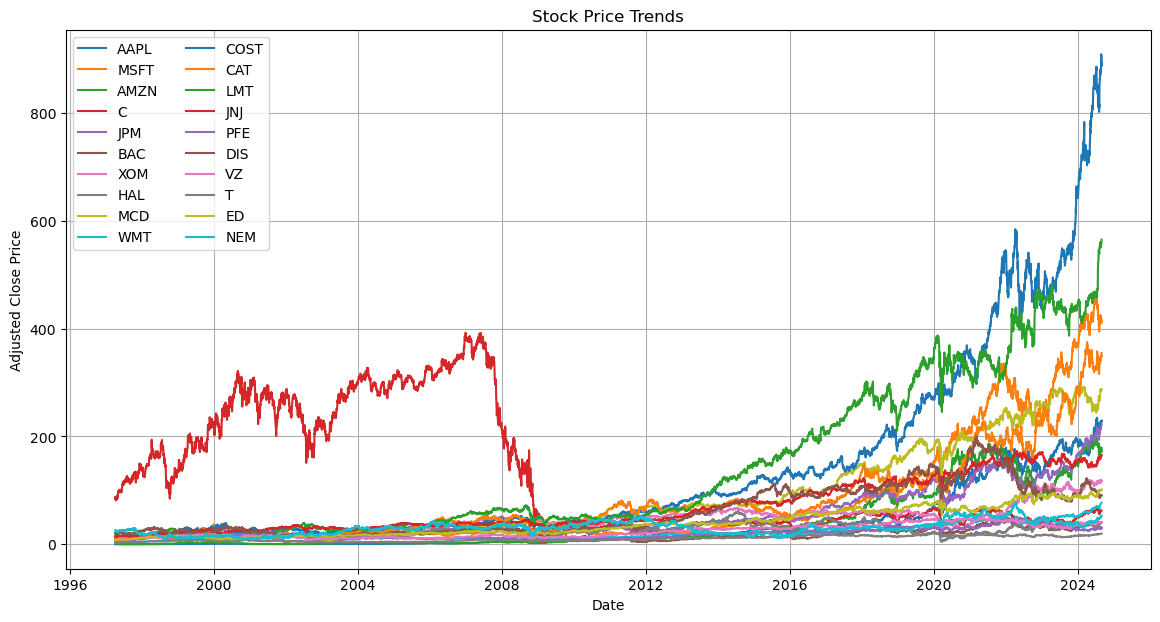

In [10]:
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd

# Define your list of tickers
tick_list = [
    "AAPL",
    "MSFT",
    "AMZN",
    "C",
    "JPM",
    "BAC",
    "XOM",
    "HAL",
    "MCD",
    "WMT",
    "COST",
    "CAT",
    "LMT",
    "JNJ",
    "PFE",
    "DIS",
    "VZ",
    "T",
    "ED",
    "NEM",
]

# Download adjusted close prices
start_date = "1997-04-01"
end_date = "2024-09-01"

data = yf.download(
    tick_list,
    start=start_date,
    end=end_date,
    progress=False,
    group_by="ticker",
    auto_adjust=True,
    threads=True,
)

# Extract adjusted close prices
if len(tick_list) == 1:
    adj_close = data["Close"].to_frame()
    adj_close.columns = tick_list
else:
    adj_close = data.xs("Close", level=1, axis=1)

# Plot the price trends
plt.figure(figsize=(14, 7))

for ticker in tick_list:
    plt.plot(adj_close.index, adj_close[ticker], label=ticker)

plt.title("Stock Price Trends")
plt.xlabel("Date")
plt.ylabel("Adjusted Close Price")
plt.legend(loc="upper left", ncol=2)
plt.grid(True)
plt.show()

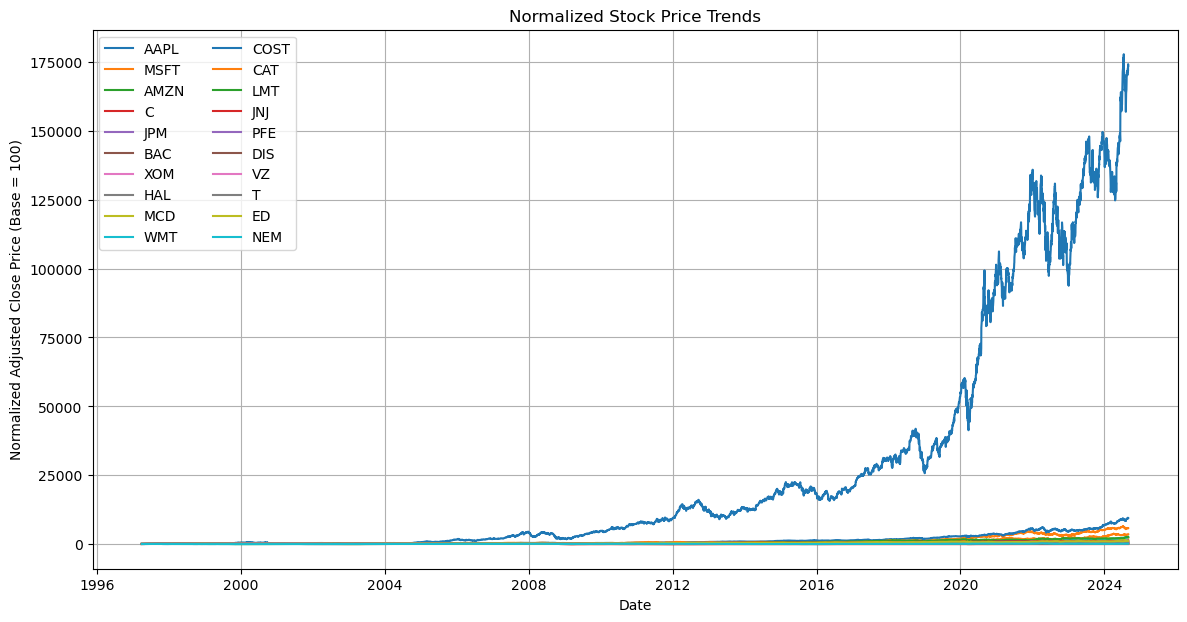

In [11]:
# Normalize the adjusted close prices
normalized_prices = adj_close / adj_close.iloc[0] * 100

# Plot the normalized price trends
plt.figure(figsize=(14, 7))

for ticker in tick_list:
    plt.plot(normalized_prices.index, normalized_prices[ticker], label=ticker)

plt.title("Normalized Stock Price Trends")
plt.xlabel("Date")
plt.ylabel("Normalized Adjusted Close Price (Base = 100)")
plt.legend(loc="upper left", ncol=2)
plt.grid(True)
plt.show()

C:\Users\zhang\AppData\Local\Temp\ipykernel_53848\580785779.py:148: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  factor_5 = pdr.get_data_famafrench(
C:\Users\zhang\AppData\Local\Temp\ipykernel_53848\580785779.py:157: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  mom_df = pdr.get_data_famafrench(
C:\Users\zhang\AppData\Local\Temp\ipykernel_53848\580785779.py:164: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  st_df = pdr.get_data_famafrench(
C:\Users\zhang\AppData\Local\Temp\ipykernel_53848\580785779.py:171: FutureWarning: The arg

Factor Data Shape: (6868, 8), Asset Data Shape: (6868, 20)
X Train Shape: (6180, 8) 
Y Train Shape: (6180, 20) 
X Test Shape: (791, 8) 
Y Test Shape: (791, 20)

X Train Head:
             Mkt-RF     SMB     HML     RMW     CMA  Mom     ST_Rev  LT_Rev
Date                                                                      
1997-05-16 -0.0113  0.0108  0.0037 -0.0044  0.0047 -0.0036  0.0113  0.0069
1997-05-19  0.0027 -0.0004 -0.0028 -0.0001  0.0006  0.0024  0.0016  0.0000
1997-05-20  0.0091 -0.0055 -0.0021  0.0030 -0.0079 -0.0001 -0.0050 -0.0078
1997-05-21 -0.0013  0.0073 -0.0073 -0.0013 -0.0006 -0.0056  0.0022  0.0010
1997-05-22 -0.0027  0.0064  0.0041 -0.0008  0.0008 -0.0011  0.0029  0.0005

X Test Tail:
             Mkt-RF     SMB     HML     RMW     CMA  Mom     ST_Rev  LT_Rev
Date                                                                      
2024-08-23  0.0129  0.0190  0.0085 -0.0048  0.0068  0.0013  0.0078 -0.0012
2024-08-26 -0.0034  0.0033  0.0016  0.0013 -0.0006 -0.0045 

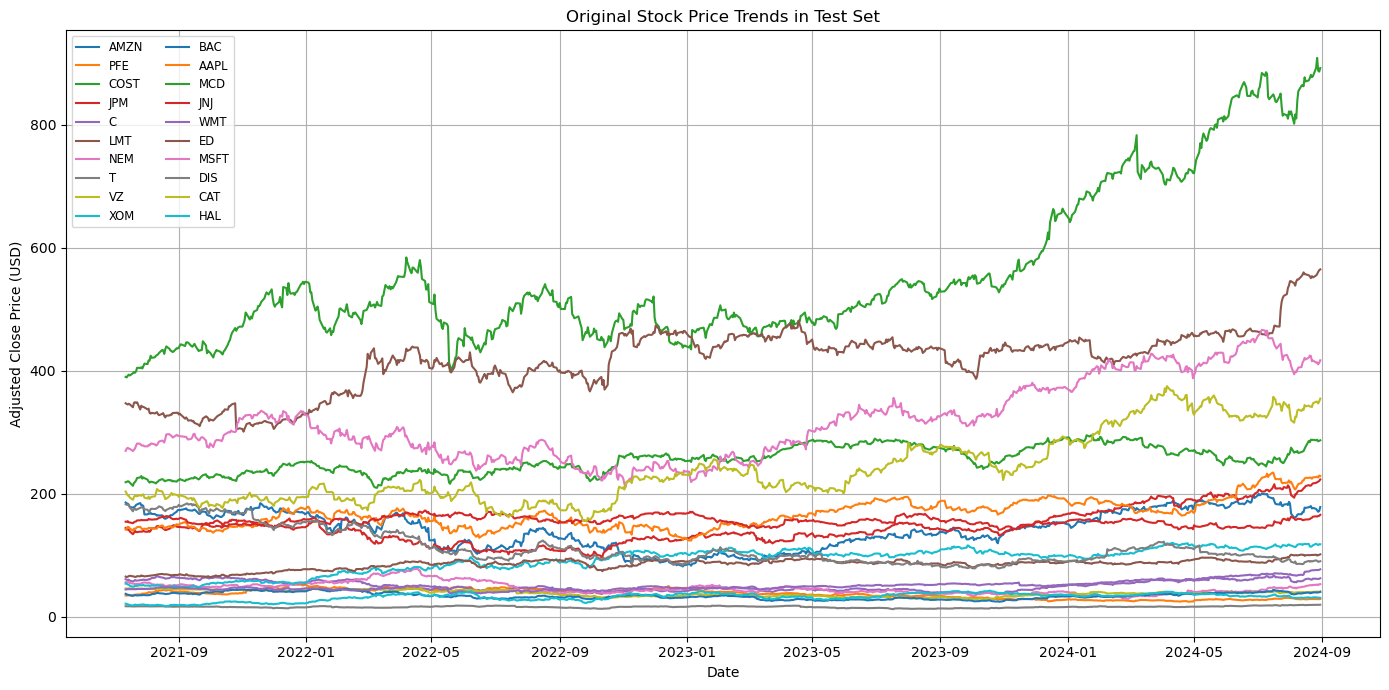

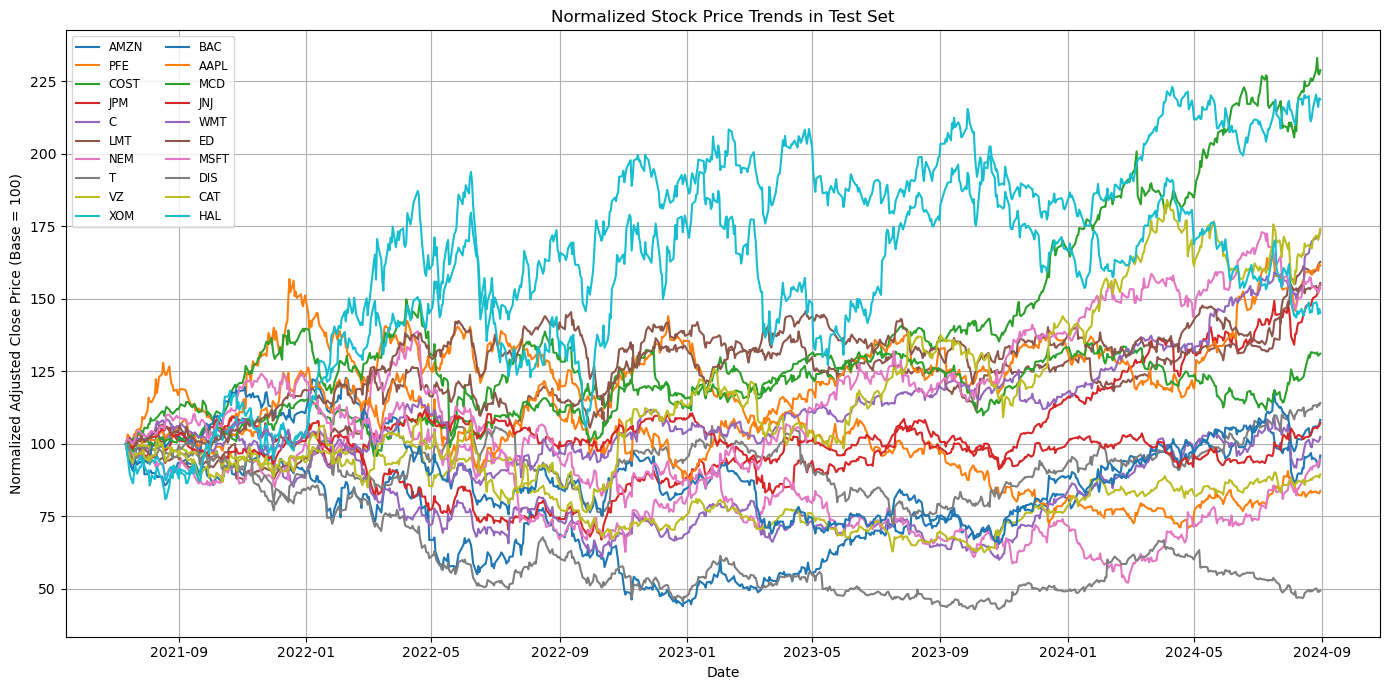

In [14]:
import os
import pandas as pd
import yfinance as yf
from pandas_datareader import data as pdr
import numpy as np
import matplotlib.pyplot as plt


# Define the TrainTest class
class TrainTest:
    def __init__(
        self,
        data: pd.DataFrame,
        number_of_observation_per_window: int,
        split_ratio_list: list[float],
    ) -> None:
        self.data: pd.DataFrame = data
        self.number_of_observation_per_window: int = number_of_observation_per_window
        self.split_ratio: list[float] = split_ratio_list

        num_total_observations: int = self.data.shape[0]
        num_observations_cumulative_split: list[float] = (
            num_total_observations * np.cumsum(split_ratio_list)
        )
        self.cumulative_number_window_observation: list[int] = [
            round(num_observation_cumulative_split)
            for num_observation_cumulative_split in num_observations_cumulative_split
        ]

    def split_update(self, split_ratio_list: list[float]) -> None:
        self.split_ratio: list[float] = split_ratio_list
        num_observations_total: int = self.data.shape[0]
        num_observations_cumulative_split: list[float] = (
            num_observations_total * np.cumsum(split_ratio_list)
        )
        self.cumulative_number_window_observation = [
            round(i) for i in num_observations_cumulative_split
        ]

    def train(self) -> pd.DataFrame:
        return self.data[: self.cumulative_number_window_observation[0]]

    def test(self) -> pd.DataFrame:
        if (
            self.cumulative_number_window_observation[0]
            - self.number_of_observation_per_window
            < 0
        ):
            raise ValueError(
                "The number of observations per window exceeds the number of observations of train data in the dataset."
            )
        return self.data[
            self.cumulative_number_window_observation[0]
            - self.number_of_observation_per_window : self.cumulative_number_window_observation[
                1
            ]
        ]

    def shape(self):
        return self.data.shape


def AV_yFinance(
    start: str,
    end: str,
    split: list[float],
    freq: str = "weekly",
    n_obs: int = 104,
    n_y: int | None = None,
    use_cache: bool = False,
    save_results: bool = False,
) -> tuple[TrainTest, TrainTest, pd.DataFrame]:
    """
    Fetches and processes asset and factor data.

    Returns:
        X_train_test (TrainTest): Training and testing sets for factors.
        Y_train_test (TrainTest): Training and testing sets for asset returns.
        adj_close (pd.DataFrame): Adjusted close prices for all assets.
    """

    if use_cache:
        X = pd.read_pickle(f"./cache/factor_{freq}.pkl")
        Y = pd.read_pickle(f"./cache/asset_{freq}.pkl")
    else:
        # Define the list of tickers
        tick_list = [
            "AAPL",
            "MSFT",
            "AMZN",
            "C",
            "JPM",
            "BAC",
            "XOM",
            "HAL",
            "MCD",
            "WMT",
            "COST",
            "CAT",
            "LMT",
            "JNJ",
            "PFE",
            "DIS",
            "VZ",
            "T",
            "ED",
            "NEM",
        ]

        if n_y is not None:
            tick_list = tick_list[:n_y]

        # Download asset data using yfinance
        data = yf.download(
            tick_list,
            start=start,
            end=end,
            progress=False,
            group_by="ticker",
            auto_adjust=True,  # Adjusted close prices
            threads=True,  # Enable multi-threading for faster downloads
        )

        if data.empty:
            raise ValueError(
                "No data downloaded. Please check the ticker symbols and date range."
            )

        # Extract Adjusted Close prices
        if len(tick_list) == 1:
            # For single ticker, data['Close'] is a Series, convert to DataFrame
            adj_close = data["Close"].to_frame()
            adj_close.columns = tick_list
        else:
            # For multiple tickers, use xs to extract 'Close' for all tickers
            try:
                adj_close = data.xs("Close", level=1, axis=1)
            except KeyError:
                raise KeyError("Close prices not found in the downloaded data.")

        # Compute daily returns as percentage change
        Y = adj_close.pct_change().dropna()

        # Download factor data from Kenneth French's data library
        dl_freq = "_daily"

        try:
            # 5-Factor Model
            factor_5 = pdr.get_data_famafrench(
                "F-F_Research_Data_5_Factors_2x3" + dl_freq,
                start=start,
                end=end,
            )[0]
            rf_df = factor_5["RF"]
            factor_5 = factor_5.drop(["RF"], axis=1)

            # Momentum Factor
            mom_df = pdr.get_data_famafrench(
                "F-F_Momentum_Factor" + dl_freq,
                start=start,
                end=end,
            )[0]

            # Short-Term Reversal Factor
            st_df = pdr.get_data_famafrench(
                "F-F_ST_Reversal_Factor" + dl_freq,
                start=start,
                end=end,
            )[0]

            # Long-Term Reversal Factor
            lt_df = pdr.get_data_famafrench(
                "F-F_LT_Reversal_Factor" + dl_freq,
                start=start,
                end=end,
            )[0]

            # Concatenate all factors and convert to decimal
            X = pd.concat([factor_5, mom_df, st_df, lt_df], axis=1) / 100
        except Exception as e:
            raise ValueError(f"Failed to download factor data: {e}")

        # Align factor data (X) with asset returns (Y) based on dates

        # Remove timezone from Y.index if present
        if Y.index.tz is not None:
            Y.index = Y.index.tz_convert(None)

        # Ensure X.index is also timezone-naive
        if X.index.tz is not None:
            X.index = X.index.tz_convert(None)

        # Now, perform the alignment
        try:
            X = X.loc[Y.index]
        except KeyError as e:
            missing_dates = Y.index.difference(X.index)
            if not missing_dates.empty:
                print(f"Missing dates in factor data: {missing_dates}")
                # Optionally, you can drop missing dates or handle them differently
                Y = Y.loc[Y.index.intersection(X.index)]
                X = X.loc[X.index.intersection(Y.index)]
            else:
                raise e  # Re-raise if no missing dates found

        # Resample data if frequency is not daily
        freq_lower = freq.lower()
        if freq_lower in ["weekly", "wk", "1wk"]:
            Y = Y.resample("W-FRI").apply(lambda x: (x + 1).prod() - 1)
            X = X.resample("W-FRI").apply(lambda x: (x + 1).prod() - 1)
            adj_close = adj_close.resample("W-FRI").last()
        elif freq_lower in ["monthly", "1mo"]:
            Y = Y.resample("M").apply(lambda x: (x + 1).prod() - 1)
            X = X.resample("M").apply(lambda x: (x + 1).prod() - 1)
            adj_close = adj_close.resample("M").last()
        # Add more resampling frequencies if needed

        # Handle missing values by forward and backward filling using ffill() and bfill()
        Y = Y.ffill().bfill()
        X = X.ffill().bfill()
        adj_close = adj_close.ffill().bfill()

        # Convert the index to 'YYYY-MM-DD' format
        X.index = pd.to_datetime(X.index.strftime("%Y-%m-%d"))
        Y.index = pd.to_datetime(Y.index.strftime("%Y-%m-%d"))
        adj_close.index = pd.to_datetime(adj_close.index.strftime("%Y-%m-%d"))

        # Optionally save the results to cache
        if save_results:
            os.makedirs("./cache", exist_ok=True)
            X.to_pickle(f"./cache/factor_{freq}.pkl")
            Y.to_pickle(f"./cache/asset_{freq}.pkl")

    print(f"Factor Data Shape: {X.shape}, Asset Data Shape: {Y.shape}")

    # Partition dataset into training and testing sets. Lag the data by one observation
    X_train_test = TrainTest(X[:-1], n_obs, split)
    Y_train_test = TrainTest(Y[1:], n_obs, split)

    return X_train_test, Y_train_test, adj_close


# Parameters
start_paddling = "1997-04-01"
end_paddling = "2024-09-01"  # Data frequency and start/end dates
daily_frequency = "daily"

# Call the AV_yFinance function
xf_train_test, yf_train_test, adj_close = AV_yFinance(
    start=start_paddling,
    end=end_paddling,
    split=[0.9, 0.1],
    freq=daily_frequency,
    n_obs=104,
    n_y=20,
    use_cache=False,
    save_results=True,
)

# Print shapes of the train and test sets
print(
    "X Train Shape:",
    xf_train_test.train().shape,
    "\nY Train Shape:",
    yf_train_test.train().shape,
    "\nX Test Shape:",
    xf_train_test.test().shape,
    "\nY Test Shape:",
    yf_train_test.test().shape,
)

# Display head and tail of training and testing sets
print("\nX Train Head:\n", xf_train_test.train().head())
print("\nX Test Tail:\n", xf_train_test.test().tail())
print("\nY Train Head:\n", yf_train_test.train().head())
print("\nY Test Tail:\n", yf_train_test.test().tail())

# --- Visualization of the Test Set ---

# Step 1: Extract test set indices
test_indices = yf_train_test.test().index

# Step 2: Extract adjusted close prices for the test set
adj_close_test = adj_close.loc[test_indices]

# Step 3: Plotting

# ---- Option A: Plot Original Adjusted Close Prices ----
plt.figure(figsize=(14, 7))
for ticker in adj_close_test.columns:
    plt.plot(adj_close_test.index, adj_close_test[ticker], label=ticker)

plt.title("Original Stock Price Trends in Test Set")
plt.xlabel("Date")
plt.ylabel("Adjusted Close Price (USD)")
plt.legend(loc="upper left", ncol=2, fontsize="small")
plt.grid(True)
plt.tight_layout()
plt.show()

# ---- Option B: Plot Normalized Adjusted Close Prices ----
# Normalize the adjusted close prices in the test set
normalized_prices_test = adj_close_test / adj_close_test.iloc[0] * 100

plt.figure(figsize=(14, 7))
for ticker in normalized_prices_test.columns:
    plt.plot(normalized_prices_test.index, normalized_prices_test[ticker], label=ticker)

plt.title("Normalized Stock Price Trends in Test Set")
plt.xlabel("Date")
plt.ylabel("Normalized Adjusted Close Price (Base = 100)")
plt.legend(loc="upper left", ncol=2, fontsize="small")
plt.grid(True)
plt.tight_layout()
plt.show()